In [398]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score,confusion_matrix,log_loss
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor,DMatrix,plot_tree

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [399]:
train_df = pd.read_csv('train_df_final.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final_blanced.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [400]:
y = train_df['label'].values
y_org = train_df_org['label'].values

In [401]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_org = pd.DataFrame()
model_predictions_org['label'] = y_org
model_predictions_test = pd.DataFrame()

## Anomaly based

In [402]:
features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

cat_features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [403]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [404]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred),average='micro')
    return 'f1_err', err

### catboost

In [405]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}

In [406]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [407]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9532710	test: 0.9525581	best: 0.9525581 (0)	total: 6.56ms	remaining: 6.55s
10:	learn: 0.9532762	test: 0.9531481	best: 0.9535810 (1)	total: 83.1ms	remaining: 7.47s
20:	learn: 0.9537179	test: 0.9533160	best: 0.9535810 (1)	total: 163ms	remaining: 7.6s
30:	learn: 0.9545096	test: 0.9534754	best: 0.9535810 (1)	total: 260ms	remaining: 8.13s
40:	learn: 0.9552059	test: 0.9537862	best: 0.9538747 (35)	total: 328ms	remaining: 7.68s
50:	learn: 0.9556051	test: 0.9540347	best: 0.9540433 (45)	total: 394ms	remaining: 7.33s
60:	learn: 0.9557341	test: 0.9540176	best: 0.9541148 (55)	total: 464ms	remaining: 7.15s
70:	learn: 0.9559561	test: 0.9542836	best: 0.9542836 (70)	total: 546ms	remaining: 7.14s
80:	learn: 0.9559883	test: 0.9544525	best: 0.9544610 (78)	total: 619ms	remaining: 7.02s
90:	learn: 0.9561983	test: 0.9547103	best: 0.9547103 (88)	total: 706ms	remaining: 7.06s
100:	learn: 0.9563843	test: 0.9546131	best: 0.9548075 (92)	total: 769ms	remaining: 6.85s
110:	

In [408]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9138915985194579, 0.00109574406471837, 0.9126436781609195)

In [409]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8936925527219696, 0.0019181392742079796, 0.8916585113119566)

In [410]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.75396825, 0.07992821],
       [0.24603175, 0.92007179]])

In [411]:
name = 'catboost_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## LightGBM

In [412]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [413]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))
    models.append(model)

In [414]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9142452574169884, 0.000768615433601861, 0.9135278514588859)

In [415]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.895688215992171, 0.0004700342990776262, 0.8951125438949974)

In [416]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.7       , 0.08007426],
       [0.3       , 0.91992574]])

In [417]:
name = 'lgb_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## K-NN

In [418]:
knn_params = {
    'n_neighbors':15,
    'weights':'uniform'    
}

In [419]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [420]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9117108878375522, 0.001250383548715244, 0.9103448275862069)

In [421]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8921382380596014, 0.0003527867578311166, 0.891716078521674)

In [422]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.64670659, 0.08440476],
       [0.35329341, 0.91559524]])

In [423]:
name = 'knn_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Random forests

In [424]:
rf_params = {
    'n_estimators':50,
    'max_depth':10,
    'random_state':0,    
}

In [425]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)


In [426]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9125361058273315, 7.606512654814278e-05, 0.9124823196605375)

In [427]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8968587492564235, 0.0005646936069526574, 0.8961487536699096)

In [428]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.77911647, 0.0796746 ],
       [0.22088353, 0.9203254 ]])

In [429]:
name = 'rf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## SVC

In [430]:
svc_params = {
    'C':2,
    'kernel':'linear',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [431]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [432]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9112394746484881, 0.0008026435619151851, 0.9101838755304101)

In [433]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8900466294398711, 1.1102230246251565e-16, 0.890046629439871)

In [434]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.69230769, 0.0880875 ],
       [0.30769231, 0.9119125 ]])

In [435]:
name = 'svc_linear_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [436]:
svc_params = {
    'C':2,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [437]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [438]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9135969470383948, 0.0012302422268772803, 0.9124823196605375)

In [439]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.896628480417554, 0.00019569088379446943, 0.8964365897184964)

In [440]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.76518219, 0.07996411],
       [0.23481781, 0.92003589]])

In [441]:
name = 'svc_rbf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Base features

In [442]:
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'fare',
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference',
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare',
    'fare-additional_fare-meter_waiting_fare',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',
    'fare_per_distance_mean',
    'fare_per_distance_mean_diff',
    'avg_speed_mean',
    'avg_speed_mean_diff',
    'meter_waiting_per_duration_mean',
    'meter_waiting_per_duration_mean_diff',
    'meter_waiting_fare_per_meter_waiting_mean',
    'meter_waiting_fare_per_meter_waiting_mean_diff',
    'meter_waiting_fare_per_duration_mean',
    'meter_waiting_fare_per_duration_mean_diff',
    'addtional_fare_per_fare_mean',
    'addtional_fare_per_fare_mean_diff',
    'addtional_fare_per_distance_mean',
    'addtional_fare_per_distance_mean_diff',
    'addtional_fare_per_duration_mean',
    'addtional_fare_per_duration_mean_diff',
]

cat_features = [
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
]

In [443]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

### Catboost

In [444]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [445]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [446]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9648677	test: 0.9632484	best: 0.9632484 (0)	total: 48.6ms	remaining: 48.6s
10:	learn: 0.9698117	test: 0.9702933	best: 0.9713853 (3)	total: 385ms	remaining: 34.6s
20:	learn: 0.9724266	test: 0.9752664	best: 0.9761112 (19)	total: 708ms	remaining: 33s
30:	learn: 0.9747203	test: 0.9771925	best: 0.9774895 (28)	total: 1.03s	remaining: 32.2s
40:	learn: 0.9764801	test: 0.9775528	best: 0.9775785 (31)	total: 1.34s	remaining: 31.3s
50:	learn: 0.9780687	test: 0.9750240	best: 0.9775785 (31)	total: 1.64s	remaining: 30.6s
60:	learn: 0.9791467	test: 0.9690462	best: 0.9775785 (31)	total: 1.96s	remaining: 30.2s
70:	learn: 0.9799024	test: 0.9610568	best: 0.9775785 (31)	total: 2.33s	remaining: 30.5s
80:	learn: 0.9807941	test: 0.9477033	best: 0.9775785 (31)	total: 2.69s	remaining: 30.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9775784753
bestIteration = 31

Shrink model to first 32 iterations.
Learning rate set to 0.057693
0:	learn: 0.9644

In [447]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9546173563927064, 0.0051738533962423115, 0.9473032714412025)

In [448]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9505689559227064, 0.004347838439132529, 0.945253583558805)

In [449]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.91096634, 0.04281441],
       [0.08903366, 0.95718559]])

In [450]:
name = 'catboost_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [451]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [452]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))
    models.append(model)

In [453]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9545584531927993, 0.004861253674952765, 0.9478337754199824)

In [454]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9576881008577515, 0.0008628682730189044, 0.9564791894536872)

In [455]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.91637011, 0.0313072 ],
       [0.08362989, 0.9686928 ]])

In [456]:
name = 'lgb_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Linear prediction difference

In [457]:
features = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duration_diff',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [458]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### Catboost

In [459]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [460]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [461]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9691234	test: 0.9694540	best: 0.9694540 (0)	total: 25.1ms	remaining: 25.1s
10:	learn: 0.9729085	test: 0.9740557	best: 0.9740557 (10)	total: 245ms	remaining: 22s
20:	learn: 0.9743467	test: 0.9757077	best: 0.9759786 (16)	total: 459ms	remaining: 21.4s
30:	learn: 0.9751710	test: 0.9761380	best: 0.9761471 (29)	total: 662ms	remaining: 20.7s
40:	learn: 0.9760513	test: 0.9764943	best: 0.9765925 (35)	total: 872ms	remaining: 20.4s
50:	learn: 0.9765681	test: 0.9772312	best: 0.9773251 (48)	total: 1.08s	remaining: 20.1s
60:	learn: 0.9771278	test: 0.9778889	best: 0.9778889 (60)	total: 1.36s	remaining: 21s
70:	learn: 0.9776946	test: 0.9776923	best: 0.9778889 (60)	total: 1.56s	remaining: 20.5s
80:	learn: 0.9781680	test: 0.9778718	best: 0.9778889 (60)	total: 1.79s	remaining: 20.3s
90:	learn: 0.9787397	test: 0.9778718	best: 0.9780643 (86)	total: 2s	remaining: 20s
100:	learn: 0.9793646	test: 0.9777692	best: 0.9781626 (94)	total: 2.21s	remaining: 19.7s
110:	learn:

In [462]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553246012361752, 0.0053365005527038585, 0.9478337754199824)

In [463]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9514132749985608, 0.0018210417230432024, 0.9490530194001495)

In [464]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.86604096, 0.03235201],
       [0.13395904, 0.96764799]])

In [465]:
name = 'catboost_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [466]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [467]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))
    models.append(model)


In [468]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9547352670090806, 0.005060771846612412, 0.9480106100795755)

In [469]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9571316178304837, 0.0030009889432215655, 0.9548673075816015)

In [470]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89282551, 0.03270615],
       [0.10717449, 0.96729385]])

In [471]:
name = 'lgb_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## knn

In [472]:
knn_params = {
    'n_neighbors':10,
    'weights':'uniform'    
}

In [473]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [474]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9461303661628006, 0.005300943405481293, 0.9400530503978781)

In [475]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9424903574923723, 0.00028591070223850124, 0.9420873870243508)

In [476]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.81581312, 0.0389807 ],
       [0.18418688, 0.9610193 ]])

In [477]:
name = 'knn_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## SVM

In [478]:
svc_params = {
    'C':1,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'auto'
}

In [479]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [480]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9100607123993946, 7.585878828588588e-05, 0.910007072135785)

In [481]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9628691497323124, 0.0005420699975754836, 0.962120776005987)

In [482]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[1.       , 0.0320336],
       [0.       , 0.9679664]])

In [483]:
name = 'svm_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## unit differences

In [484]:
features = [
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff'
]

cat_features = []

In [485]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### Catboost

In [486]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [487]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [488]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9646330	test: 0.9632381	best: 0.9632381 (0)	total: 22ms	remaining: 22s
10:	learn: 0.9729626	test: 0.9748802	best: 0.9748802 (10)	total: 150ms	remaining: 13.5s
20:	learn: 0.9742904	test: 0.9763825	best: 0.9763825 (20)	total: 298ms	remaining: 13.9s
30:	learn: 0.9751687	test: 0.9771330	best: 0.9773208 (29)	total: 488ms	remaining: 15.3s
40:	learn: 0.9756214	test: 0.9773164	best: 0.9774104 (39)	total: 624ms	remaining: 14.6s
50:	learn: 0.9766707	test: 0.9772137	best: 0.9774104 (39)	total: 791ms	remaining: 14.7s
60:	learn: 0.9774220	test: 0.9775854	best: 0.9776837 (52)	total: 970ms	remaining: 14.9s
70:	learn: 0.9779482	test: 0.9779659	best: 0.9779659 (70)	total: 1.14s	remaining: 14.9s
80:	learn: 0.9786173	test: 0.9778718	best: 0.9779659 (70)	total: 1.29s	remaining: 14.6s
90:	learn: 0.9790907	test: 0.9776708	best: 0.9781542 (85)	total: 1.45s	remaining: 14.5s
100:	learn: 0.9793256	test: 0.9779617	best: 0.9781542 (85)	total: 1.59s	remaining: 14.2s
110:	l

In [489]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553245908145191, 0.005610738932294572, 0.9476569407603891)

In [490]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9542916354844282, 0.003867728290194174, 0.9488803177709977)

In [491]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.88545151, 0.02961131],
       [0.11454849, 0.97038869]])

In [492]:
name = 'catboost_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [493]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':8
}

In [494]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))
    models.append(model)

In [495]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9542636974951758, 0.005833100479115211, 0.9464190981432361)

In [496]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9550975764204709, 0.0005338563407688795, 0.9543492026941454)

In [497]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.88695652, 0.0319909 ],
       [0.11304348, 0.9680091 ]])

In [498]:
name = 'lgb_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### KNN

In [499]:
knn_params = {
    'n_neighbors':10,
    'weights':'distance'    
}

In [500]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [501]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9448926381838638, 0.004681426802319368, 0.9382847038019452)

In [502]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9785658089152419, 0.0018661802109130705, 0.9759369063381498)

In [503]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.95105917, 0.01436082],
       [0.04894083, 0.98563918]])

In [504]:
name = 'knn_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [505]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'auto'
}

In [506]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [507]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9077031566362397, 0.0007540118952659524, 0.9071618037135278)

In [508]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9592999827298371, 0.0007387168865703476, 0.9586667434229463)

In [509]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.97260274, 0.03336469],
       [0.02739726, 0.96663531]])

In [510]:
name = 'rbf_svm_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## diff norm

In [511]:
features = [
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [512]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### KNN

In [513]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [514]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [515]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9516113860343972, 0.0069344895200864915, 0.941998231653404)

In [516]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9810603880029934, 0.0026931775869810715, 0.9774336537908007)

In [517]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.96333573, 0.01194145],
       [0.03666427, 0.98805855]])

In [518]:
name = 'knn_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [519]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [520]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [521]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9243247079539328, 0.012349504958989706, 0.9137199434229137)

In [522]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9121524379713315, 0.023365763841682145, 0.8954579471533014)

In [523]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.9147541, 0.042923 ],
       [0.0852459, 0.957077 ]])

In [524]:
name = 'svm_rbf_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Unit features

In [525]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
]

cat_features = []

In [526]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

## Catboost

In [527]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [528]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [529]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9637438	test: 0.9634802	best: 0.9634802 (0)	total: 14.3ms	remaining: 14.3s
10:	learn: 0.9706593	test: 0.9747052	best: 0.9749786 (9)	total: 126ms	remaining: 11.4s
20:	learn: 0.9737268	test: 0.9762337	best: 0.9763359 (19)	total: 254ms	remaining: 11.8s
30:	learn: 0.9750238	test: 0.9774249	best: 0.9774249 (30)	total: 377ms	remaining: 11.8s
40:	learn: 0.9757680	test: 0.9782713	best: 0.9783691 (39)	total: 517ms	remaining: 12.1s
50:	learn: 0.9766909	test: 0.9786337	best: 0.9787397 (46)	total: 656ms	remaining: 12.2s
60:	learn: 0.9773466	test: 0.9784297	best: 0.9787397 (46)	total: 793ms	remaining: 12.2s
70:	learn: 0.9778670	test: 0.9786214	best: 0.9787397 (46)	total: 940ms	remaining: 12.3s
80:	learn: 0.9782390	test: 0.9787152	best: 0.9789110 (77)	total: 1.19s	remaining: 13.5s
90:	learn: 0.9785625	test: 0.9787071	best: 0.9790049 (82)	total: 1.46s	remaining: 14.5s
100:	learn: 0.9789821	test: 0.9782171	best: 0.9790049 (82)	total: 1.6s	remaining: 14.2s
110:

In [530]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9566801773015498, 0.0053043619760975045, 0.9492484526967285)

In [531]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9557308157273616, 0.0029790683398620158, 0.9523343503540382)

In [532]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89635854, 0.03560644],
       [0.10364146, 0.96439356]])

In [533]:
name = 'catboost_unit'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## lgb

In [534]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':8
}

In [535]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))
    models.append(model)

In [536]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9556781767604575, 0.005921952343040445, 0.9473032714412025)

In [537]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9599140329668221, 0.002546151690328971, 0.9578608024869034)

In [538]:
best_model = models[np.argmax(validation_scores)]
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89923143, 0.02994429],
       [0.10076857, 0.97005571]])

In [539]:
name = 'lgb_unit'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## KNN

In [540]:
knn_params = {
    'n_neighbors':10,
    'weights':'distance'    
}

In [541]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [542]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9322210820930521, 0.0034656648894080167, 0.9273209549071618)

In [543]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9724636846852034, 0.0010258527741349337, 0.9711012607218928)

In [544]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.97534922, 0.02152381],
       [0.02465078, 0.97847619]])

In [545]:
name = 'knn_unit'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [546]:
svc_params = {
    'C':10,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'auto'
}

In [547]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))
    models.append(model)

In [548]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.90640651503574, 0.0004718120059338958, 0.9057471264367816)

In [549]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9615067257690021, 0.0006346913594896239, 0.9607391629727707)

In [550]:
best_model = models[np.argmax(validation_scores)]
y_hat = best_model.predict(train)
confusion_matrix(y,y_hat,normalize='pred')

array([[0.9751434 , 0.03178192],
       [0.0248566 , 0.96821808]])

In [551]:
model_predictions_train.to_csv('stack_2_train.csv',index=False)
model_predictions_test.to_csv('stack_2_test.csv',index=False)

In [552]:
model_predictions_train = pd.read_csv('stack_2_train.csv')
model_predictions_test = pd.read_csv('stack_2_test.csv')
for col in model_predictions_test.columns:
    model_predictions_train[col] = np.round(model_predictions_train[col]).astype(int)
    model_predictions_test[col] = np.round(model_predictions_test[col]).astype(int)

In [553]:
best = 'catboost_unit'

In [554]:
in_corrects = model_predictions_train[model_predictions_train[best] != model_predictions_train['label']]
models = [col for col in in_corrects if (col != best and col != 'label')]
scores = {}
for model in models:
    y_hat = in_corrects[model]
    score = log_loss(in_corrects['label'].values, y_hat.values)
    scores[model] = score

In [555]:
scores

{'catboost_anomaly': 27.537669025751256,
 'lgb_anomaly': 27.161710656366754,
 'knn_anomaly': 27.819614957148772,
 'rf_anomaly': 27.53766141053763,
 'svc_linear_anomaly': 27.913615428371497,
 'svc_rbf_anomaly': 27.161715007917394,
 'catboost_base': 31.531943849669975,
 'lgb_base': 31.3909507580495,
 'catboost_pred_diff': 28.524412880551463,
 'lgb_pred_diff': 28.853355783897353,
 'knn_pred_diff': 27.913514254819106,
 'svm_pred_diff': 28.007601757054644,
 'catboost_unit_diff': 29.182300863018575,
 'lgb_unit_diff': 29.323279812099468,
 'knn_unit_diff': 28.712404032007978,
 'rbf_svm_unit_diff': 27.631652090771418,
 'knn_unit_diff_norm': 28.712393153131366,
 'svm_rbf_unit_diff_norm': 29.229367459777205,
 'lgb_unit': 31.531919916141447,
 'knn_unit': 28.66546471810558}

In [556]:
cmp_models = [
    best,
    'label',
    'lgb_anomaly',
    'rbf_svm_unit_diff'
]

in_corrects[cmp_models]

,catboost_unit,label,lgb_anomaly,rbf_svm_unit_diff
40,1,0,1,1
41,0,1,1,1
70,0,1,1,1
102,1,0,1,1
141,1,0,1,1
...,...,...,...,...
16848,0,1,1,1
16864,1,0,1,1
16872,1,0,1,1
16904,1,0,1,1


In [562]:
in_corrects[in_corrects['label']==0].sum().sort_values()

label                       0
knn_pred_diff             500
catboost_pred_diff        508
lgb_pred_diff             510
catboost_unit_diff        514
lgb_unit_diff             518
knn_unit_diff_norm        521
knn_unit_diff             531
lgb_unit                  553
lgb_anomaly               556
lgb_base                  558
svc_rbf_anomaly           560
rf_anomaly                573
catboost_base             575
knn_anomaly               577
knn_unit                  579
rbf_svm_unit_diff         580
catboost_anomaly          580
svm_rbf_unit_diff_norm    583
svc_linear_anomaly        593
catboost_unit             596
svm_pred_diff             596
dtype: int64

In [566]:
(in_corrects[in_corrects['label']==1].shape[0] - in_corrects[in_corrects['label']==1].sum()).sort_values()

label                       0
svm_pred_diff               0
svc_linear_anomaly          1
catboost_anomaly            6
rbf_svm_unit_diff           8
rf_anomaly                 13
knn_anomaly                15
svc_rbf_anomaly            18
lgb_anomaly                22
knn_unit                   31
svm_rbf_unit_diff_norm     39
knn_unit_diff              80
knn_unit_diff_norm         90
knn_pred_diff              94
catboost_base              96
catboost_pred_diff         99
lgb_pred_diff             104
lgb_unit_diff             106
catboost_unit_diff        107
lgb_base                  110
lgb_unit                  118
catboost_unit             139
dtype: int64

# Stack level 2

In [559]:
model_predictions_train = pd.read_csv('stack_2_train.csv')
model_predictions_test = pd.read_csv('stack_2_test.csv')

In [560]:
model_predictions_train.columns

Index(['label', 'catboost_anomaly', 'lgb_anomaly', 'knn_anomaly', 'rf_anomaly',
       'svc_linear_anomaly', 'svc_rbf_anomaly', 'catboost_base', 'lgb_base',
       'catboost_pred_diff', 'lgb_pred_diff', 'knn_pred_diff', 'svm_pred_diff',
       'catboost_unit_diff', 'lgb_unit_diff', 'knn_unit_diff',
       'rbf_svm_unit_diff', 'knn_unit_diff_norm', 'svm_rbf_unit_diff_norm',
       'catboost_unit', 'lgb_unit', 'knn_unit'],
      dtype='object')

## Selective level 2

In [669]:
features = [
    'catboost_unit',
    'knn_pred_diff',
    'catboost_pred_diff',
    'lgb_pred_diff',
    'catboost_unit_diff',
    'lgb_unit_diff',
    'svm_pred_diff',
    'svc_linear_anomaly',
    'catboost_anomaly',
    'rbf_svm_unit_diff',
    'rf_anomaly'
]
cat_cols = [
    'knn_pred_diff',
    'svm_pred_diff',
    'svc_linear_anomaly',
    'svc_linear_anomaly',
    'rbf_svm_unit_diff',
    'rf_anomaly',
]

In [665]:
for each in cat_cols:
    model_predictions_train[each] = model_predictions_train[each].astype(int)
    model_predictions_test[each] = model_predictions_test[each].astype(int)

In [666]:
train = model_predictions_train[features]
test = model_predictions_test[features]
y = train_df['label']

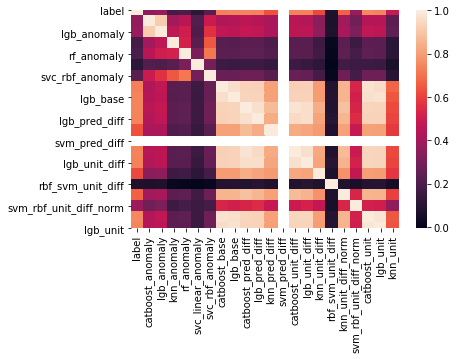

In [667]:
sns.heatmap(model_predictions_train.corr())

### Catboost

In [581]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [582]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_cols)

In [583]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_cols)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9747696	test: 0.9757136	best: 0.9757136 (0)	total: 16.1ms	remaining: 16.1s
10:	learn: 0.9753614	test: 0.9783992	best: 0.9786045 (7)	total: 75.3ms	remaining: 6.77s
20:	learn: 0.9755043	test: 0.9786865	best: 0.9787850 (16)	total: 124ms	remaining: 5.8s
30:	learn: 0.9756379	test: 0.9779923	best: 0.9787850 (16)	total: 179ms	remaining: 5.59s
40:	learn: 0.9757716	test: 0.9779923	best: 0.9787850 (16)	total: 248ms	remaining: 5.79s
50:	learn: 0.9759662	test: 0.9778936	best: 0.9787850 (16)	total: 296ms	remaining: 5.5s
60:	learn: 0.9760600	test: 0.9779838	best: 0.9787850 (16)	total: 343ms	remaining: 5.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787849566
bestIteration = 16

Shrink model to first 17 iterations.
Learning rate set to 0.057693
0:	learn: 0.9752620	test: 0.9774277	best: 0.9774277 (0)	total: 13.3ms	remaining: 13.3s
10:	learn: 0.9758273	test: 0.9775130	best: 0.9778247 (8)	total: 63.9ms	remaining: 5.75s
20:	learn: 0.975

In [584]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9570338778857045, 0.004451143606348504, 0.9508399646330681)

In [585]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

### Logistice regression

In [586]:
logistic_reg_params = {
    'penalty':'l2',
    'C':1.0,
    'solver':'lbfgs',
    'max_iter':100
}

In [591]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = LogisticRegression(**logistic_reg_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    models.append(model)

In [594]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9562676256257682, 0.005251597127235231, 0.9490716180371352)

In [595]:
submission_df['prediction'] = np.round(test_preds).astype(int)
submission_df.to_csv('submission.csv',index=False)

### Extratrees

In [623]:
et_params = {
    'n_estimators':50,
    'max_depth':3,
    'random_state':0    
}

In [624]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [625]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.956031846079644, 0.005490538768764707, 0.9483642793987621)

## All predictions

In [698]:
features = model_predictions_test.columns
cat_cols = [
    'knn_anomaly', 
    'rf_anomaly',
    'svc_linear_anomaly', 
    'svc_rbf_anomaly', 
    'knn_pred_diff', 
    'svm_pred_diff',
    'knn_unit_diff',
    'rbf_svm_unit_diff', 
    'knn_unit_diff_norm', 
    'svm_rbf_unit_diff_norm',
    'knn_unit'
]

In [699]:
for each in cat_cols:
    model_predictions_train[each] = model_predictions_train[each].astype(int)
    model_predictions_test[each] = model_predictions_test[each].astype(int)

In [700]:
train = model_predictions_train[features]
test = model_predictions_test[features]
y = train_df['label']

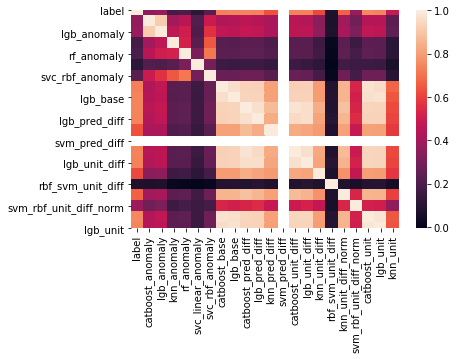

In [701]:
sns.heatmap(model_predictions_train.corr())

### Catboost

In [702]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3,
    'l2_leaf_reg':5
}

In [703]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_cols)

In [704]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_cols)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

0:	learn: 0.9730399	test: 0.9743395	best: 0.9743395 (0)	total: 7.71ms	remaining: 7.7s
10:	learn: 0.9750096	test: 0.9785797	best: 0.9785838 (4)	total: 60.6ms	remaining: 5.45s
20:	learn: 0.9750900	test: 0.9789940	best: 0.9789940 (19)	total: 113ms	remaining: 5.27s
30:	learn: 0.9752637	test: 0.9793010	best: 0.9793993 (26)	total: 164ms	remaining: 5.13s
40:	learn: 0.9754342	test: 0.9790964	best: 0.9793993 (26)	total: 229ms	remaining: 5.37s
50:	learn: 0.9755137	test: 0.9789940	best: 0.9793993 (26)	total: 281ms	remaining: 5.23s
60:	learn: 0.9755488	test: 0.9789900	best: 0.9793993 (26)	total: 331ms	remaining: 5.09s
70:	learn: 0.9755816	test: 0.9786947	best: 0.9793993 (26)	total: 406ms	remaining: 5.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9793993069
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 0.9736115	test: 0.9763930	best: 0.9763930 (0)	total: 5.09ms	remaining: 5.08s
10:	learn: 0.9753988	test: 0.9779702	best: 0.9787193 (6)	total: 68ms	remain

In [705]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9572694906853322, 0.006067925546634067, 0.9487179487179487)

In [706]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

### Extratrees

In [658]:
et_params = {
    'n_estimators':10,
    'max_depth':3,
    'random_state':0    
}

In [659]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [660]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9556192839822065, 0.005589591053385371, 0.9480106100795755)

## Knn classifier

In [661]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [662]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [663]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9544994666196441, 0.005494382289687058, 0.946949602122016)